# ETL and EDA of the Yelp big dataset

### Spark related imports

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

In [2]:
%%time
# spark-ui : http://localhost:4040/
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("Cdac_proj").setMaster("local[*]")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.getOrCreate()

Wall time: 7.26 s


### Import data using spark

In [3]:
%%time
df1 = spark.read.json("yelp_academic_dataset_business.json") #geotag location can be used for visualization.
#df2 = spark.read.json("yelp_academic_dataset_checkin.json") # useless info mostly
df3 = spark.read.json("yelp_academic_dataset_review.json") #Textual reviews.
df4 = spark.read.json("yelp_academic_dataset_tip.json") # Has tips which can be parsed for text.
#df5 = spark.read.json("yelp_academic_dataset_user.json") # Not really important data for the business. 

Wall time: 5min 9s


### Imports

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col,isnan,when,count
from pyspark.ml.feature import Bucketizer
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df1.limit(10).toPandas()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,921 Pearl St,"(None, None, 'beer_and_wine', {'touristy': Fal...",6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Boulder,"(11:0-23:0, 11:0-23:0, 11:0-23:0, 11:0-23:0, 1...",1,40.017544,-105.283348,Oskar Blues Taproom,80302,86,4.0,CO
1,7000 NE Airport Way,"(None, None, u'beer_and_wine', {'romantic': Fa...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"(5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-1...",1,45.588906,-122.593331,Flying Elephants at PDX,97218,126,4.0,OR
2,4720 Hawthorne Ave,"(None, None, None, None, None, None, None, Fal...",bvN78flM8NLprQ1a1y5dRg,"Antiques, Fashion, Used, Vintage & Consignment...",Portland,"(11:0-18:0, None, 11:0-18:0, 11:0-18:0, 11:0-1...",1,45.511907,-122.613693,The Reclaimory,97214,13,4.5,OR
3,2566 Enterprise Rd,"(None, None, None, None, None, None, None, Non...",oaepsyvc0J17qwi8cfrOWg,"Beauty & Spas, Hair Salons",Orange City,None,1,28.914482,-81.295979,Great Clips,32763,8,3.0,FL
4,1046 Memorial Dr SE,"(None, None, None, None, None, None, None, Non...",PE9uqAjdw0E4-8mjGl3wVA,"Gyms, Active Life, Interval Training Gyms, Fit...",Atlanta,"(16:0-19:0, 16:0-19:0, 9:0-11:0, None, 16:0-19...",1,33.747027,-84.353424,Crossfit Terminus,30316,14,4.0,GA
5,3755 Main St,"(None, None, u'none', {'romantic': False, 'int...",D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",Vancouver,"(17:0-21:0, 17:0-21:0, 17:0-21:0, 17:0-21:0, 1...",1,49.251342,-123.101333,Bob Likes Thai Food,V5V,169,3.5,BC
6,2511 Edgewater Dr,"(True, None, None, None, None, None, None, Non...",t35jsh9YnMtttm69UCp7gw,"Dentists, Health & Medical, Orthodontists",Orlando,"(8:0-17:30, 0:0-0:0, None, None, 8:0-17:30, 8:...",1,28.573998,-81.389284,Escott Orthodontics,32804,7,4.5,FL
7,740 S High St,None,jFYIsSb7r1QeESVUnXPHBw,"Breakfast & Brunch, Restaurants",Columbus,"(None, None, 8:0-14:0, 8:0-14:0, None, None, N...",1,39.947007,-82.997471,Boxwood Biscuit,43206,11,4.5,OH
8,"7801 N Lamar Blvd, Ste A140","(None, None, None, None, None, None, None, Tru...",N3_Gs3DnX4k9SgpwJxdEfw,"Shopping, Jewelry Repair, Appraisal Services, ...",Austin,"(12:15-17:0, 12:15-17:0, None, None, 12:15-17:...",1,30.346169,-97.711458,Lane Wells Jewelry Repair,78752,30,5.0,TX
9,"615 W Slaughter Ln, Ste 113","(None, None, None, None, None, None, None, Non...",tXvdYGvlEceDljN8gt2_3Q,"Barbers, Beauty & Spas",Austin,"(9:0-19:0, 9:0-17:0, 9:0-16:0, None, 9:0-19:0,...",0,30.172706,-97.799920,Capital City Barber Shop,78748,5,4.0,TX


In [6]:
df1.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [7]:
print("Total Number of rows in business: ",df1.count())

Total Number of rows in business:  160585


In [8]:
%%time
df1_1 = df1.where("is_open!=0")
df1_2 = df1_1.drop("attributes","postal_code","state","address","city","name","hours","is_open")
df1_2.limit(10).toPandas()

Wall time: 560 ms


,business_id,categories,latitude,longitude,review_count,stars
0,6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",40.017544,-105.283348,86,4.0
1,tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",45.588906,-122.593331,126,4.0
2,bvN78flM8NLprQ1a1y5dRg,"Antiques, Fashion, Used, Vintage & Consignment...",45.511907,-122.613693,13,4.5
3,oaepsyvc0J17qwi8cfrOWg,"Beauty & Spas, Hair Salons",28.914482,-81.295979,8,3.0
4,PE9uqAjdw0E4-8mjGl3wVA,"Gyms, Active Life, Interval Training Gyms, Fit...",33.747027,-84.353424,14,4.0
5,D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",49.251342,-123.101333,169,3.5
6,t35jsh9YnMtttm69UCp7gw,"Dentists, Health & Medical, Orthodontists",28.573998,-81.389284,7,4.5
7,jFYIsSb7r1QeESVUnXPHBw,"Breakfast & Brunch, Restaurants",39.947007,-82.997471,11,4.5
8,N3_Gs3DnX4k9SgpwJxdEfw,"Shopping, Jewelry Repair, Appraisal Services, ...",30.346169,-97.711458,30,5.0
9,rYs_1pNB_RMtn5WQh55QDA,"Food, Shopping, Convenience Stores, Souvenir S...",39.998449,-105.281006,5,3.5


In [9]:
print("New Number of rows in business: ",df1_2.count())

New Number of rows in business:  123248


In [10]:
df1_2 = df1_2.selectExpr("business_id","categories","latitude","longitude","review_count","stars as b_stars")
#df1_2.printSchema()
df1_2.limit(10).toPandas()

,business_id,categories,latitude,longitude,review_count,b_stars
0,6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",40.017544,-105.283348,86,4.0
1,tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",45.588906,-122.593331,126,4.0
2,bvN78flM8NLprQ1a1y5dRg,"Antiques, Fashion, Used, Vintage & Consignment...",45.511907,-122.613693,13,4.5
3,oaepsyvc0J17qwi8cfrOWg,"Beauty & Spas, Hair Salons",28.914482,-81.295979,8,3.0
4,PE9uqAjdw0E4-8mjGl3wVA,"Gyms, Active Life, Interval Training Gyms, Fit...",33.747027,-84.353424,14,4.0
5,D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",49.251342,-123.101333,169,3.5
6,t35jsh9YnMtttm69UCp7gw,"Dentists, Health & Medical, Orthodontists",28.573998,-81.389284,7,4.5
7,jFYIsSb7r1QeESVUnXPHBw,"Breakfast & Brunch, Restaurants",39.947007,-82.997471,11,4.5
8,N3_Gs3DnX4k9SgpwJxdEfw,"Shopping, Jewelry Repair, Appraisal Services, ...",30.346169,-97.711458,30,5.0
9,rYs_1pNB_RMtn5WQh55QDA,"Food, Shopping, Convenience Stores, Souvenir S...",39.998449,-105.281006,5,3.5


In [11]:
from pyspark.sql.functions import col,isnan, when, count # put in main import later.

df1_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1_2.columns]).show()

+-----------+----------+--------+---------+------------+-------+
|business_id|categories|latitude|longitude|review_count|b_stars|
+-----------+----------+--------+---------+------------+-------+
|          0|       100|       0|        0|           0|      0|
+-----------+----------+--------+---------+------------+-------+



In [12]:
df1_3 = df1_2.na.fill(value="unknown",subset=["categories"])

In [13]:
df1_3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1_3.columns]).show()

+-----------+----------+--------+---------+------------+-------+
|business_id|categories|latitude|longitude|review_count|b_stars|
+-----------+----------+--------+---------+------------+-------+
|          0|         0|       0|        0|           0|      0|
+-----------+----------+--------+---------+------------+-------+



In [14]:
df1_3.describe().toPandas()

,summary,business_id,categories,latitude,longitude,review_count,b_stars
0,count,123248,123248,123248,123248,123248,123248
1,mean,None,None,38.62141183418293,-93.95538471923348,54.63898805660133,3.695252661300792
2,stddev,None,None,7.145750589517901,19.84153141727244,138.62276599870103,0.9653925970169139
3,min,--0DF12EMHYI8XIgoFha6A,"3D Printing, Graphic Design, Local Services, P...",27.998972,-123.3939285,5,1.0
4,max,zzxIO4bjWCQrvCJ0O5mmvA,unknown,49.49,71.113271,9185,5.0


In [47]:
df1_3.groupby("review_count").count().sort("review_count").toPandas().head()

,review_count,count
0,5,10555
1,6,8519
2,7,7192
3,8,6005
4,9,5052


In [39]:
star_business = df1_3.groupby("b_stars").count().sort("b_stars",ascending=False).toPandas()

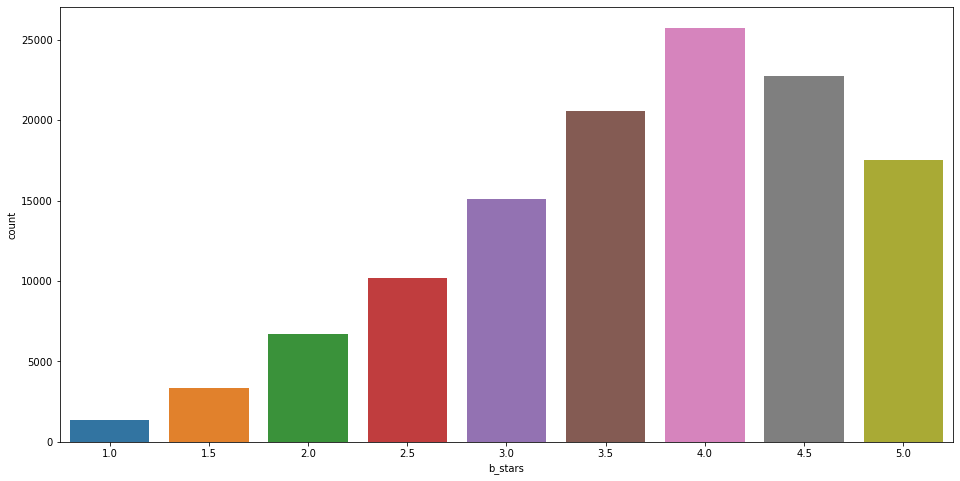

In [41]:
fig = plt.figure(figsize=(16,8))
ax = sns.barplot(x="b_stars", y="count", data=star_business)

In [9]:
df2.limit(10).toPandas()

,business_id,date
0,--0r8K_AQ4FZfLsX3ZYRDA,2017-09-03 17:13:59
1,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."
2,--164t1nclzzmca7eDiJMw,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010..."
3,--2aF9NhXnNVpDV0KS3xBQ,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015..."
4,--2mEJ63SC_8_08_jGgVIg,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015..."
5,--6COJIAjkQwSUZci_4PJQ,"2012-09-23 20:58:03, 2012-10-08 22:49:59, 2012..."
6,--DzGwfuJH12DjYz95VW0Q,"2014-08-02 14:12:55, 2015-02-21 17:37:57"
7,--EoF6KmeDuki2vBWhPqCw,"2012-08-27 21:10:37, 2012-09-21 22:35:50"
8,--JKSSgnfoOjVDFGv692BA,"2011-08-15 22:43:08, 2015-11-16 13:19:35, 2017..."
9,--JuLhLvq3gyjNnXT9Q95w,2016-06-08 15:40:03


In [10]:
df2.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [20]:
df3.limit(10).toPandas()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,buF9druCkbuXLX526sGELQ,1,2014-10-11 03:34:02,1,lWC-xP3rd6obsecCYsGZRg,4.0,Apparently Prides Osteria had a rough summer a...,3,ak0TdVmGKo4pwqdJSTLwWw
1,RA4V8pr014UyUbDvI-LW2A,0,2015-07-03 20:38:25,0,8bFej1QE5LXp4O05qjGqXA,4.0,This store is pretty good. Not as great as Wal...,1,YoVfDbnISlW0f7abNQACIg
2,_sS2LBIGNT5NQb6PD1Vtjw,0,2013-05-28 20:38:06,0,NDhkzczKjLshODbqDoNLSg,5.0,I called WVM on the recommendation of a couple...,0,eC5evKn1TWDyHCyQAwguUw
3,0AzLzHfOJgL7ROwhdww2ew,1,2010-01-08 02:29:15,1,T5fAqjjFooT4V0OeZyuk1w,2.0,I've stayed at many Marriott and Renaissance M...,1,SFQ1jcnGguO0LYWnbbftAA
4,8zehGz9jnxPqXtOc7KaJxA,0,2011-07-28 18:05:01,0,sjm_uUcQVxab_EeLCqsYLg,4.0,The food is always great here. The service fro...,0,0kA0PAJ8QFMeveQWHFqz2A
5,xGXzsc-hzam-VArK6eTvtw,0,2018-01-21 04:41:03,0,J4a2TuhDasjn2k3wWtHZnQ,1.0,"This place used to be a cool, chill place. Now...",2,RNm_RWkcd02Li2mKPRe7Eg
6,EXOsmAB1s71WePlQk0WZrA,0,2006-04-16 02:58:44,0,28gGfkLs3igtjVy61lh77Q,2.0,"The setting is perfectly adequate, and the foo...",0,Q8c91v7luItVB0cMFF_mRA
7,DbXHNl890xSXNiyRczLWAg,0,2017-12-02 18:16:13,0,9vqwvFCBG3FBiHGmOHMmiA,5.0,Probably one of the better breakfast sandwiche...,0,XGkAG92TQ3MQUKGX9sLUhw
8,mD-A9KOWADXvfrZfwDs-jw,0,2012-05-28 15:00:47,0,2l_TDrQ7p-5tANOyiOlkLQ,4.0,I am definitely a fan of Sports Authority. Th...,1,LWUnzwK0ILquLLZcHHE1Mw
9,EEHhKSxUvJkoPSzeGKkpVg,0,2014-05-07 18:10:21,0,KKVFopqzcVfcubIBxmIjVA,5.0,I work in the Pru and this is the most afforda...,0,99RsBrARhhx60UnAC4yDoA


In [21]:
df3.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [22]:
df3_1 = df3.selectExpr("business_id","cool","funny","useful","review_id","stars as r_stars","date as r_datetime","text as r_text","user_id as r_user_id")
df3_1.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- r_stars: double (nullable = true)
 |-- r_datetime: string (nullable = true)
 |-- r_text: string (nullable = true)
 |-- r_user_id: string (nullable = true)



In [23]:
print("Total Number of rows in review: ",df3_1.count())

Total Number of rows in review:  8635403


In [24]:
df3_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3_1.columns]).show()

+-----------+----+-----+------+---------+-------+----------+------+---------+
|business_id|cool|funny|useful|review_id|r_stars|r_datetime|r_text|r_user_id|
+-----------+----+-----+------+---------+-------+----------+------+---------+
|          0|   0|    0|     0|        0|      0|         0|     0|        0|
+-----------+----+-----+------+---------+-------+----------+------+---------+



In [25]:
df3_1.describe().toPandas()

,summary,business_id,cool,funny,useful,review_id,r_stars,r_datetime,r_text,r_user_id
0,count,8635403,8635403,8635403,8635403,8635403,8635403,8635403,8635403,8635403
1,mean,None,0.5022635307234647,0.4194357808199571,1.2492944452042365,None,3.730958705690979,None,3.5,None
2,stddev,None,2.2443782574142226,1.8696752485350616,3.20423644733357,None,1.456808728407596,None,None,None
3,min,--0DF12EMHYI8XIgoFha6A,0,0,0,---29scUlbDR81-A1BDxdg,1.0,2004-10-12 11:14:43,"! ... , . . \n\nA fantastic di...",---2PmXbF47D870stH1jqA
4,max,zzzKmD9Mj6WtJwJUhA_1dg,732,610,758,zzzzqrZuBZ3g9iprEPYnoA,5.0,2021-01-28 15:38:54,"･Sadly, 5 out of 6 beers in our flight were un...",zzzqnB-6DlYUbqAPxUxg4A


In [42]:
star_review = df3_1.groupby("r_stars").count().sort("r_stars",ascending=False).toPandas()

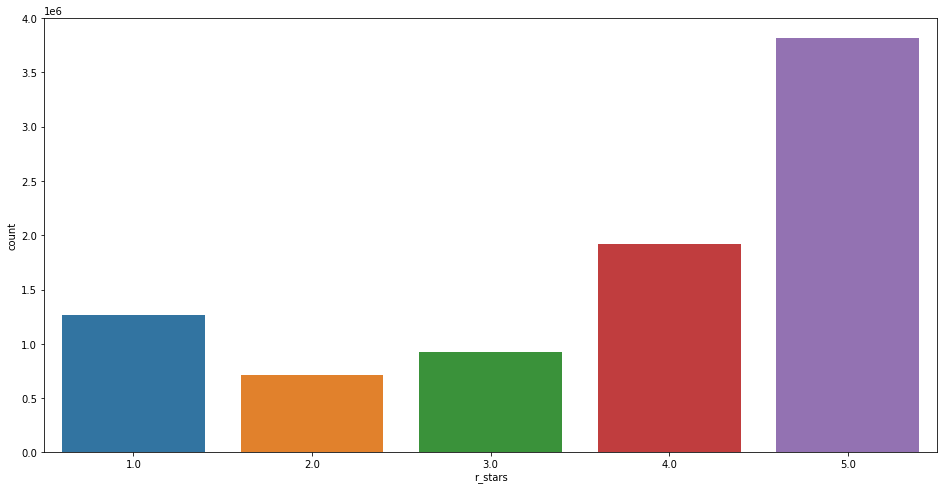

In [48]:
fig = plt.figure(figsize=(16,8))
ax = sns.barplot(x="r_stars", y="count", data=star_review)

In [30]:
df3_1.groupby("cool").count().sort("cool",ascending=False).toPandas()

,cool,count
0,732,1
1,721,1
2,717,1
3,708,1
4,705,1
...,...,...
202,4,71554
203,3,145669
204,2,364606
205,1,1206387


In [31]:
df3_1.groupby("funny").count().sort("funny",ascending=False).toPandas()

,funny,count
0,610,1
1,529,1
2,392,1
3,288,1
4,267,1
...,...,...
185,4,66832
186,3,126998
187,2,296906
188,1,958665


In [32]:
df4.limit(10).toPandas()

,business_id,compliment_count,date,text,user_id
0,ENwBByjpoa5Gg7tKgxqwLg,0,2011-07-22 19:07:35,Carne asada chips...,WCjg0jdHXMlwbqS9tZUx8Q
1,jKO4Og6ucdX2-YCTKQVYjg,0,2014-09-10 07:33:29,Best happy hour from 3pm to 6pm! $1 off martin...,42-Z02y9bABShAGZhuSzrQ
2,9Bto7mky640ocgezVKSfVg,0,2013-12-13 23:23:41,"Nice people, skilled staff, clean location - b...",5u7E3LYp_3eB8dLuUBazXQ
3,XWFjKtRGZ9khRGtGg2ZvaA,0,2017-07-11 23:07:16,"1/2-price bowling & the ""Very"" Old Fashion are...",wDWoMG5N9oI4DJ-p7z8EBg
4,mkrx0VhSMU3p3uhyJGCoWA,0,2016-11-30 08:46:36,"Solid gold's. Great sauna. Great staff, too. E...",JmuFlorjjRshHTKzTwNtgg
5,VQftVUvHfMQdDTmnO0iQqg,0,2010-03-22 21:40:26,Try a few different styles and instructors of ...,MHmKe1NQ1pCpIrbK4XREDw
6,2PxZ-fICnd432NJHefXrcA,0,2011-10-08 17:14:20,On The Border was very fresh and fast for non-...,S5tOE7JAvaeXBEibnAV02g
7,oQyf1788YWsiDLupGva6sw,0,2015-06-09 14:35:57,Cold cuts are the best,fTsVDajAyDJ-YzsSdfXSDw
8,OQ2oHkcWA8KNC1Lsvj1SBA,0,2018-03-22 15:28:09,Water Ave coffee served here--& @ L Jeans!,g3HFkZgloxLQCvoJ5Zs5gg
9,Wqetc51pFQzz04SXh_AORA,0,2014-06-07 12:09:55,So busy...,sNVpZLDSlCudlXLsnJpg7A


In [33]:
df4.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [34]:
df4_1 = df4.selectExpr("business_id","compliment_count","date as t_datetime","text as t_text","user_id as t_user_id")
df4_1.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- t_datetime: string (nullable = true)
 |-- t_text: string (nullable = true)
 |-- t_user_id: string (nullable = true)



In [35]:
print("Total Number of rows in tips: ",df4_1.count())

Total Number of rows in tips:  1162119


In [36]:
df4_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4_1.columns]).show()

+-----------+----------------+----------+------+---------+
|business_id|compliment_count|t_datetime|t_text|t_user_id|
+-----------+----------------+----------+------+---------+
|          0|               0|         0|     0|        0|
+-----------+----------------+----------+------+---------+



In [37]:
df4_1.describe().toPandas()

,summary,business_id,compliment_count,t_datetime,t_text,t_user_id
0,count,1162119,1162119,1162119,1162119,1162119
1,mean,None,0.010819029720708464,None,5.6036167710853888E16,None
2,stddev,None,0.11503726395367103,None,5.9302434499783616E17,None
3,min,--0zrn43LEaB4jUWTQH_Bg,0,2009-04-16 03:04:32,"Visa, Mastercard and Cash Only",--0666UC6t7DJWO4mevaug
4,max,zzwK-TJsCJX5wZrdtKemPg,12,2021-01-28 14:20:15,ｖ（＾＿＾ｖ）,zzwsXDw71s88s0QeH9JqQg


In [38]:
df4_1.groupby("compliment_count").count().sort("compliment_count",ascending=False).toPandas()

,compliment_count,count
0,12,1
1,10,1
2,9,1
3,8,2
4,6,5
5,5,8
6,4,23
7,3,98
8,2,681
9,1,10708


In [18]:
df5.limit(10).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.85,2541,361,2541,1710,147,163,1212,323,5691,...,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014",1357,"xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",10030,Jane,1220,15038,q_QQ5kBBwlCcbL1s4NVK3g,2005-03-14 20:26:35
1,4.09,2205,232,2205,1632,96,87,1187,294,3293,...,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",1025,"XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",10289,Gabi,2136,21272,dIIKEfOgo0KqUfGQvGikPg,2007-08-10 19:01:51
2,3.76,31,0,31,22,0,1,5,1,20,...,130,"2010,2011",16,"GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",128,Jason,119,188,D6ErcUnFALnCQN4b1W_TlA,2007-02-07 15:47:53
3,3.77,1566,219,1566,1180,90,129,1120,326,4510,...,4035,"2009,2010,2011,2012,2013,2014",420,"HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",4722,Kat,987,7234,JnPIjvC0cmooNDfsa9BmXg,2009-02-09 16:14:29
4,3.72,310,16,310,248,15,19,77,44,131,...,1124,"2009,2010,2011",47,"-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",727,Christine,495,1577,37Hc8hr3cw0iHLoPzLK6Ow,2008-03-03 04:57:05
5,3.59,24,0,24,18,0,4,10,2,15,...,140,"2010,2011,2012,2013,2014,2015,2016",17,"2ptwW5l68069vNtW8J-WOg, 4TVFuz8L4TsDtx_ObSin9g...",101,Natasha,229,476,n-QwITZYrXlKQRiV30MqNg,2008-06-25 14:53:17
6,3.86,2,0,2,0,0,0,3,0,1,...,16,,1,"DlT1HhrcYfDhjJNUyskU5g, C0ly5C7RzTlzh0M55YspDw...",14,Bridget,51,53,eCJoZqpV1fDKJGAsXmWXqQ,2009-07-22 16:47:01
7,3.79,12,1,12,4,0,5,4,2,6,...,44,"2010,2011",4,"_Tpd51CSlnOyvDTpOtgG5w, jVYzrVblDFSuL3GHtt8ZSA...",47,Steven,51,136,cojecOwQJpsYDxnjtgzteQ,2010-07-04 17:18:40
8,3.43,30,6,30,17,0,8,17,1,47,...,121,"2010,2011,2012,2013,2014,2015",23,"VGfzq5na6LZUwxwWO5eVLA, 35uHDsVOEsWbLdEg8Ttobg...",106,Clara,299,381,1jXmzuIFKxTnEnR0pxO0Hg,2010-10-01 17:29:36
9,3.88,24,2,24,8,0,4,12,2,32,...,306,"2012,2013,2014,2015,2016,2017,2018",25,"vePby1OhpTiQiX75XrN97A, UG8cewYtZdep2hzSekIqYg...",220,Antoinette,288,752,-8QoOIfvwwxJ4sY201WP5A,2007-08-04 20:21:09


In [19]:
df5.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [20]:
%%time
df = df3_1.join(df1_2).where(df1_2.business_id==df3_1.business_id).join(df4_1).where(df4_1.business_id==df3_1.business_id).drop(df1_2.business_id).drop(df4_1.business_id)
df.limit(10).toPandas()

Wall time: 5min 12s


,business_id,cool,funny,useful,review_id,r_stars,r_datetime,r_text,r_user_id,attributes,categories,latitude,longitude,review_count,b_stars,compliment_count,t_datetime,t_text,t_user_id
0,-36nnCT71XE0InJXKBIpuw,0,0,1,FKAf01wJCJsulBXdxnIaPQ,1.0,2016-03-08 18:39:24,Customer service is absolutely terrible. The c...,5hjAPltdXiHM3Ng4iw94_Q,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2014-07-05 03:16:29,Lots of kids mooching for cigarettes out in fr...,xUdhjbEBS-miHJriaLNrjw
1,-36nnCT71XE0InJXKBIpuw,0,0,1,FKAf01wJCJsulBXdxnIaPQ,1.0,2016-03-08 18:39:24,Customer service is absolutely terrible. The c...,5hjAPltdXiHM3Ng4iw94_Q,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2013-01-07 06:01:07,Great staff! Sometimes the produce is a bit w...,CkHdONzx_e38l4aoFElkEw
2,-36nnCT71XE0InJXKBIpuw,0,0,1,yN9h_GTzoQJQX0FEhTdwug,5.0,2017-04-11 17:56:21,Love my neighborhood Safeway! The cashiers kno...,WiVyzMjKiOOyF2kK1_pqjw,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2014-07-05 03:16:29,Lots of kids mooching for cigarettes out in fr...,xUdhjbEBS-miHJriaLNrjw
3,-36nnCT71XE0InJXKBIpuw,0,0,1,yN9h_GTzoQJQX0FEhTdwug,5.0,2017-04-11 17:56:21,Love my neighborhood Safeway! The cashiers kno...,WiVyzMjKiOOyF2kK1_pqjw,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2013-01-07 06:01:07,Great staff! Sometimes the produce is a bit w...,CkHdONzx_e38l4aoFElkEw
4,-36nnCT71XE0InJXKBIpuw,0,1,2,IltU14wyyH6tU5ew7WPIVg,1.0,2015-02-06 07:09:52,This is by far my longest grocery store visit ...,tU52QQnMGbJA8o89zYAw2w,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2014-07-05 03:16:29,Lots of kids mooching for cigarettes out in fr...,xUdhjbEBS-miHJriaLNrjw
5,-36nnCT71XE0InJXKBIpuw,0,1,2,IltU14wyyH6tU5ew7WPIVg,1.0,2015-02-06 07:09:52,This is by far my longest grocery store visit ...,tU52QQnMGbJA8o89zYAw2w,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2013-01-07 06:01:07,Great staff! Sometimes the produce is a bit w...,CkHdONzx_e38l4aoFElkEw
6,-36nnCT71XE0InJXKBIpuw,0,0,0,YFlgwm1WqI-bxpe7gM-FgA,1.0,2017-02-14 17:11:55,Customer service is desperate need of attentio...,Xg7RVVk9zNXTXyvCZB5olA,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2014-07-05 03:16:29,Lots of kids mooching for cigarettes out in fr...,xUdhjbEBS-miHJriaLNrjw
7,-36nnCT71XE0InJXKBIpuw,0,0,0,YFlgwm1WqI-bxpe7gM-FgA,1.0,2017-02-14 17:11:55,Customer service is desperate need of attentio...,Xg7RVVk9zNXTXyvCZB5olA,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2013-01-07 06:01:07,Great staff! Sometimes the produce is a bit w...,CkHdONzx_e38l4aoFElkEw
8,-36nnCT71XE0InJXKBIpuw,0,0,2,qe1GnINw3fD630Sp9VWevA,2.0,2017-05-05 19:38:13,Safeway oh how I loathe thee anymore. I used t...,wKBjsz3O0DYzXIxr8UQ5dQ,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2014-07-05 03:16:29,Lots of kids mooching for cigarettes out in fr...,xUdhjbEBS-miHJriaLNrjw
9,-36nnCT71XE0InJXKBIpuw,0,0,2,qe1GnINw3fD630Sp9VWevA,2.0,2017-05-05 19:38:13,Safeway oh how I loathe thee anymore. I used t...,wKBjsz3O0DYzXIxr8UQ5dQ,"(None, None, None, None, None, None, None, Tru...","Shopping, Drugstores, Pharmacy, Grocery, Food,...",45.641232,-122.557114,28,2.0,0,2013-01-07 06:01:07,Great staff! Sometimes the produce is a bit w...,CkHdONzx_e38l4aoFElkEw


In [21]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- r_stars: double (nullable = true)
 |-- r_datetime: string (nullable = true)
 |-- r_text: string (nullable = true)
 |-- r_user_id: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |

### Kill server

In [49]:
sc.stop()